In [1]:
#@
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
#@
%cd '/content/gdrive/My Drive/Colab Notebooks'

/content/gdrive/My Drive/Colab Notebooks


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from nilearn import datasets
from nilearn.input_data import NiftiMasker
from nilearn.image import get_data

n_subjects = 100  # more subjects requires more memory

/usr/local/lib/python3.7/dist-packages/nilearn/datasets/__init__.py:96: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [ ]:
oasis_dataset = datasets.fetch_oasis_vbm(n_subjects=n_subjects)
gray_matter_map_filenames = oasis_dataset.gray_matter_maps
age = oasis_dataset.ext_vars['age'].astype(float)

# Split data into training set and test set
from sklearn.model_selection import train_test_split
gm_imgs_train, gm_imgs_test, age_train, age_test = train_test_split(
    gray_matter_map_filenames, age, train_size=.6, random_state=0)

# print basic information on the dataset
print('First gray-matter anatomy image (3D) is located at: %s' %
      oasis_dataset.gray_matter_maps[0])  # 3D data
print('First white-matter anatomy image (3D) is located at: %s' %
      oasis_dataset.white_matter_maps[0])  # 3D data


Dataset created in /root/nilearn_data/oasis1



Downloaded 887988224 of 905208634 bytes (98.1%,    0.6s remaining) ...done. (30 seconds, 0 min)
Extracting data from /root/nilearn_data/oasis1/adcb228c7b26ed4f4fba93bd32bf8d97/archive_dartel.tgz..... done.
/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:2349: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


First gray-matter anatomy image (3D) is located at: /root/nilearn_data/oasis1/OAS1_0001_MR1/mwrc1OAS1_0001_MR1_mpr_anon_fslswapdim_bet.nii.gz
First white-matter anatomy image (3D) is located at: /root/nilearn_data/oasis1/OAS1_0001_MR1/mwrc2OAS1_0001_MR1_mpr_anon_fslswapdim_bet.nii.gz


In [ ]:
data=[]
import nilearn
for i in gm_imgs_train:
  data.append(nilearn.image.get_data(i))
  

In [3]:
#@
import tensorflow as tf

In [4]:
#@
seed = 42
val_split   = 0.1
train_split = 1 - val_split
batch_size = 32 #37

ds_val =tf.keras.preprocessing.image_dataset_from_directory(
        'Alzheimer_s_Dataset/train',
        labels="inferred",
        color_mode="rgb",
        batch_size=batch_size,
        image_size=(64, 64),
        shuffle=True,
        seed=seed,
        validation_split=val_split,
        subset='validation',
        interpolation="bilinear",
        follow_links=False,
        )
ds_train =tf.keras.preprocessing.image_dataset_from_directory(
          'Alzheimer_s_Dataset/train',
          labels="inferred",
          color_mode="rgb",
          batch_size=batch_size,
          image_size=(64, 64),
          shuffle=True,
          seed=seed,
          validation_split=val_split,
          subset='training',
          interpolation="bilinear",
          follow_links=False,
          )

ds_test = tf.keras.preprocessing.image_dataset_from_directory(
          'Alzheimer_s_Dataset/test',
          labels="inferred",
          color_mode="rgb",
          batch_size=batch_size,
          image_size=(64, 64),
          shuffle=True,
          seed=seed,
          interpolation="bilinear",
          follow_links=False,
          )

IMG_SIZE=64
# def augment(image,label):
#   image, label = resize_and_rescale(image, label)
#   # Add 6 pixels of padding
#   image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE + 6, IMG_SIZE + 6) 
#    # Random crop back to the original size
#   image = tf.image.random_crop(image, size=[IMG_SIZE, IMG_SIZE, 3])
#   image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness
#   image = tf.clip_by_value(image, 0, 1)
#   return image, label

def resize_and_rescale(image, label):
   image = tf.cast(image, tf.float32)
   image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
   image = (image / 255.0)
   return image, label

# AUTOTUNE = tf.data.experimental.AUTOTUNE
# ds_train = ds_train.unbatch().map(augment).batch(batch_size).prefetch(buffer_size=AUTOTUNE)
# ds_val   = ds_val.prefetch(buffer_size=AUTOTUNE)
# ds_test  = ds_test.batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)

Found 5069 files belonging to 3 classes.
Using 506 files for validation.
Found 5069 files belonging to 3 classes.
Using 4563 files for training.
Found 1267 files belonging to 3 classes.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest',
    zoom_range=0.3,
    horizontal_flip=True, 
    validation_split=0.01)

test_datagen = ImageDataGenerator()

In [ ]:
batch_size = 16
seed = 42
tf.random.set_seed(seed)


train_ds = train_datagen.flow_from_directory('CellData/OCT/train', 
                                             target_size=(224,224), 
                                             subset='training',
                                             class_mode="categorical",
                                             seed=seed, 
                                             interpolation='bilinear',
                                             batch_size=batch_size)

val_ds   = train_datagen.flow_from_directory('CellData/OCT/train', 
                                             target_size=(224,224), 
                                             subset='validation',
                                             class_mode="categorical",
                                             seed=seed, 
                                             interpolation='bilinear',
                                             batch_size=batch_size)

test_ds = test_datagen.flow_from_directory('CellData/OCT/test',
                                           class_mode="categorical",
                                           target_size=(224,224),
                                           batch_size=batch_size)

In [5]:
#@
import matplotlib.pyplot as plt
import numpy as np

def view_image(ds):
    image, label = next(iter(ds)) # extract 1 batch from the dataset
    image = image.numpy()
    label = label.numpy()

    fig = plt.figure(figsize=(22, 22))
    for i in range(16):
        ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
        ax.imshow(image[i].astype(np.int32))
        ax.set_title(f"Label: {label[i]}")
    return image 

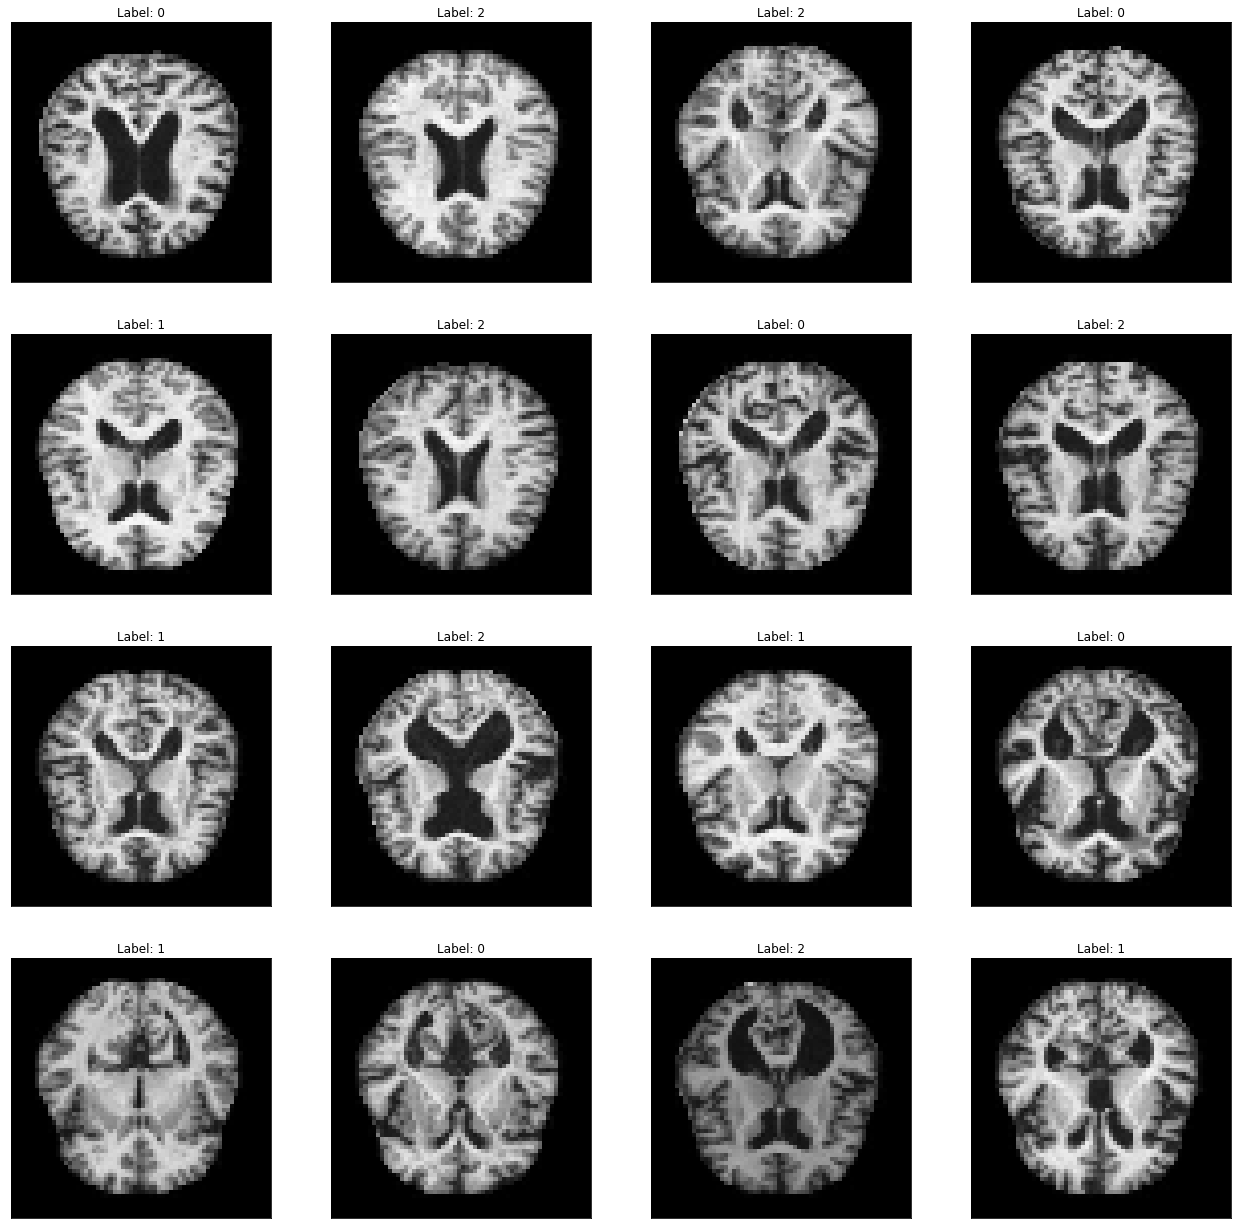

In [6]:
#@
img = view_image(ds_train)

In [7]:
#@
%cd '/content/gdrive/My Drive/Colab Notebooks'

/content/gdrive/My Drive/Colab Notebooks


In [8]:
#@
import numpy as np
trainX=[]
trainY=[]
testX=[]
testY=[]
image, label = next(iter(ds_train)) # extract 1 batch from the dataset
im,l=next(iter(ds_val))
img,lbl=next(iter(ds_test))
im=im.numpy()
l=l.numpy()
img=img.numpy()
lbl=lbl.numpy()
image = image.numpy()
label = label.numpy()
trainX=image
trainY=label
testX=img
testY=lbl
valX=im
valY=l
for i in range(1,6):
  image, label = next(iter(ds_train)) # extract 1 batch from the dataset
  image = image.numpy()
  label = label.numpy()
  im,l=next(iter(ds_val))
  img,lbl=next(iter(ds_test))
  im=im.numpy()
  l=l.numpy()
  img=img.numpy()
  lbl=lbl.numpy()
  trainX=np.concatenate((trainX, image))
  trainY=np.concatenate((trainY, label))
"""  if i<2:
    testX=np.concatenate((testX, img))
    testY=np.concatenate((testY, lbl))
    valX=np.concatenate((valX, im))
    valY=np.concatenate((valY, l))"""

'  if i<2:\n    testX=np.concatenate((testX, img))\n    testY=np.concatenate((testY, lbl))\n    valX=np.concatenate((valX, im))\n    valY=np.concatenate((valY, l))'

In [9]:
#@
print(len(trainX))
print(len(trainY))
print(len(testX))
print(len(testY))
print(len(valX))
print(len(valY))
#print(trainX)

192
192
32
32
32
32


In [10]:
#@
with open('test_X.npy', 'wb') as f:
    np.save(f, testX)
with open('test_Y.npy', 'wb') as f:
    np.save(f, testY)
with open('train_X.npy', 'wb') as f:
    np.save(f, trainX)
with open('train_Y.npy', 'wb') as f:
    np.save(f, trainY)        
with open('val_X.npy', 'wb') as f:
    np.save(f, valX)
with open('val_Y.npy', 'wb') as f:
    np.save(f, valY) 
          

In [11]:
#@
import numpy as np
train_X=np.load('./train_X.npy')
train_Y=np.load('./train_Y.npy')
test_X=np.load('./test_X.npy')
test_Y=np.load('./test_Y.npy')
val_Y=np.load('./val_Y.npy')
val_X=np.load('./val_X.npy')
outfile='OASIS.npz'
np.savez(outfile, train_X=train_X, train_Y=train_Y,test_X=test_X,test_Y=test_Y,val_Y=val_Y,val_X=val_X)

In [12]:
print(train_X.shape)

(192, 64, 64, 3)


In [ ]:
from numpy import asarray
from sklearn.preprocessing import OneHotEncoder
# define data
data = array(train_Y).reshape(len(train_Y),1)
print(data)
# define one hot encoding
encoder = OneHotEncoder(sparse=False)
# transform data
onehot = encoder.fit_transform(data)
print(onehot)

[[0]
 [2]
 [3]
 [1]
 [0]
 [1]
 [3]
 [3]
 [3]
 [3]
 [3]
 [2]
 [3]
 [0]
 [2]
 [0]
 [3]
 [1]
 [2]
 [3]
 [2]
 [3]
 [1]
 [2]
 [0]
 [0]
 [3]
 [3]
 [2]
 [3]
 [3]
 [0]
 [0]
 [3]
 [0]
 [3]
 [0]
 [3]
 [3]
 [3]
 [3]
 [2]
 [3]
 [0]
 [3]
 [0]
 [3]
 [3]
 [2]
 [0]
 [3]
 [1]
 [0]
 [0]
 [3]
 [3]
 [2]
 [3]
 [3]
 [1]
 [3]
 [0]
 [0]
 [3]
 [3]
 [3]
 [2]
 [0]
 [2]
 [0]
 [3]
 [3]
 [1]
 [0]
 [0]
 [3]
 [2]
 [0]
 [2]
 [3]
 [3]
 [0]
 [3]
 [3]
 [0]
 [0]
 [3]
 [3]
 [3]
 [1]
 [0]
 [0]
 [1]
 [3]
 [0]
 [3]
 [2]
 [3]
 [3]
 [1]
 [1]
 [3]
 [3]
 [0]
 [1]
 [3]
 [0]
 [0]
 [2]
 [3]
 [3]
 [3]
 [1]
 [0]
 [3]
 [2]
 [2]
 [3]
 [0]
 [3]
 [2]
 [3]
 [0]
 [3]
 [2]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [3]
 [3]
 [0]
 [3]
 [3]
 [2]
 [0]
 [3]
 [0]
 [0]
 [1]
 [0]
 [3]
 [3]
 [3]
 [3]
 [0]
 [0]
 [2]
 [3]
 [3]
 [3]
 [3]
 [3]
 [2]
 [3]
 [3]
 [1]
 [3]
 [0]
 [0]
 [0]
 [3]
 [3]
 [0]
 [0]
 [3]
 [1]
 [3]
 [3]
 [3]
 [0]
 [0]
 [1]
 [0]
 [3]
 [1]
 [0]
 [3]
 [0]
 [3]
 [3]
 [3]
 [0]
 [0]
 [2]
 [1]
 [3]
 [0]]
[[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0